In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
data= pd.read_csv('ps5_data.csv')

In [4]:
data

,Date,NASDAQ Close
0,21-Mar-00,4711.68
1,22-Mar-00,4864.75
2,23-Mar-00,4940.61
3,24-Mar-00,4963.03
4,27-Mar-00,4958.56
...,...,...
1496,6-Mar-06,2286.03
1497,7-Mar-06,2268.38
1498,8-Mar-06,2267.46
1499,9-Mar-06,2249.72


In [5]:
#   reshape((1,-1)).astype(float)
last_prices = data.iloc[-1,1].reshape((1,-1))
last_prices

array([[2262.04]])

In [13]:
data.iloc[1:, [1]]

,NASDAQ Close
1,4864.75
2,4940.61
3,4963.03
4,4958.56
5,4833.89
...,...
1496,2286.03
1497,2268.38
1498,2267.46
1499,2249.72


In [16]:
(data.shift(periods=1).iloc[1:, 1])

posisions= 10000
irange = [1]
df_simulation = 2262.04 * (data.iloc[1:, [1]]) / (data.shift(periods=1).iloc[1:, [1]])
df_simulation['Portfolio Value']= posisions/2262.04* (df_simulation.values)
df_simulation['Loss'] = posisions - df_simulation['Portfolio Value'] 
df_simulation

,NASDAQ Close,Portfolio Value,Loss
1,2335.527687,10324.873506,-324.873506
2,2297.313828,10155.938126,-155.938126
3,2272.304914,10045.379012,-45.379012
4,2260.002672,9990.993405,9.006595
5,2205.166931,9748.576200,251.423800
...,...,...,...
1496,2245.761878,9928.037870,71.962130
1497,2244.575222,9922.791914,77.208086
1498,2261.122571,9995.944242,4.055758
1499,2244.342405,9921.762677,78.237323


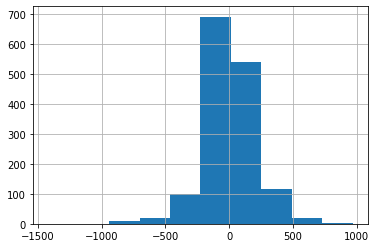

In [17]:
df_simulation['Loss'].hist()

In [19]:
alpha = 0.99
losses= df_simulation.Loss.values
VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
ES = np.mean(losses [losses > VaR])

print('VaR: ', VaR)
print('ES ', ES)

VaR:  538.9382836766908
ES  665.01654732069


# VaR and ES: With Weights

In [61]:
Lambda = 0.995
df_loss= df_simulation[['Loss']]
df_loss.reset_index(inplace = True)
n = len(df_loss)
df_loss

,index,Loss
0,1,-324.873506
1,2,-155.938126
2,3,-45.379012
3,4,9.006595
4,5,251.423800
...,...,...
1495,1496,71.962130
1496,1497,77.208086
1497,1498,4.055758
1498,1499,78.237323


In [63]:
df_loss['Weight'] = np.power( Lambda, n - df_loss['index']) * (1- Lambda) / (1- np.power(Lambda, n))
df_loss.sort_values(by = 'Loss', ascending = False,inplace = True)
df_loss['Cum Weight'] = np.cumsum(df_loss.Weight)
df_loss

,index,Loss,Weight,Cum Weight
17,18,966.851430,0.000003,0.000003
8,9,763.531555,0.000003,0.000006
197,198,723.167592,0.000007,0.000013
190,191,712.383197,0.000007,0.000020
15,16,705.811287,0.000003,0.000023
...,...,...,...,...
47,48,-793.638908,0.000003,0.999965
270,271,-812.283566,0.000011,0.999976
262,263,-892.116183,0.000010,0.999986
179,180,-1047.691867,0.000007,0.999993


In [64]:
weights = df_loss['Weight'].values
losses_sorted=df_loss['Loss'].values
cum_weights = df_loss['Cum Weight'].values
# Critial_index = np.where(cum_weights >= 1 - alpha, np.arange(n) , np.inf).argmin()
Critial_index =np.argmax(cum_weights >= 0.01)
# Critial_index= np.argwhere(cum_weights >= 0.01)
Critial_index

162

In [49]:
# vritical index VaR 和 ES
alpha=0.99
VaR  = df_loss.Loss.iloc[Critial_index]
w_for_ES = weights[0:Critial_index].tolist() + [1 - alpha - cum_weights[Critial_index-1]]
ES = np.sum( losses_sorted[0: Critial_index + 1] * w_for_ES )/ (1-alpha)

#print('Weight for ES: ', w_for_ES)
print('VaR: ', VaR)
print('ES ', ES)


VaR:  229.4014803021073
ES  271.288427579489


# VaR and ES: Extreme Value Theory

In [66]:
np.percentile(losses, 0.95 * 100, interpolation = 'higher') 

316.8203087786169

In [70]:
import scipy.optimize as opt

In [72]:
# Initialization
u = 300
tail_losses = losses_sorted[losses_sorted > u]

n_u = len(tail_losses )

# Definition the log likelihood function 
def EVT_likelihood (paras):
    beta = paras[0]
    xi = paras[1]
    return  (-1/xi -1) * np.sum( np.log(1 + xi * (tail_losses - u)/beta ) ) - n_u * np.log(beta) 


In [78]:
x0 = (10, 1) #Initial guess of beta and xi
print('Initial guess of the (beta, xi) configuration: ', x0)
print('Log likelihood for the initial guess: ', EVT_likelihood ((10, 0.3)))


res = opt.minimize( lambda x: - EVT_likelihood (x)  , x0, method='SLSQP',  options={ 'ftol': 1e-11, 'disp': True})

beta_optimal, xi_optimal =  res.x

print('Optimal (beta, xi) configuration: ', beta_optimal, xi_optimal )
print('Log likelihood for the optimal solution : ', EVT_likelihood ((beta_optimal, xi_optimal)))


Initial guess of the (beta, xi) configuration:  (10, 1)
Log likelihood for the initial guess:  -684.0302174563213
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 515.8371997734989
            Iterations: 22
            Function evaluations: 95
            Gradient evaluations: 22
Optimal (beta, xi) configuration:  112.37778496959668 0.07405735503257309
Log likelihood for the optimal solution :  -515.8371997734989


In [79]:
VaR = u + beta_optimal/xi_optimal * (np.power(n/n_u * (1-alpha),-xi_optimal) - 1)
ES  = (VaR + beta_optimal - xi_optimal * u)/(1 - xi_optimal)

print('VaR: ',  VaR)
print('ES ', ES)

VaR:  513.8908976531621
ES  652.3638147525178


# VaR and ES: Normal Distribution Approximation

In [21]:
from scipy.stats import norm

sigma = losses.std() 
VaR = 0 + sigma * norm.ppf(alpha)
ES = 0 + sigma * norm.pdf(norm.ppf(alpha))/(1-alpha)

print('VaR: ',  VaR)
print('ES ', ES)

VaR:  467.96727696068376
ES  536.1335057106866


In [6]:
posisions= 10000
df_simulation=data.copy()
df_simulation['Simulated Data']= last_prices*(df_simulation.iloc[:, 1]/df_simulation.shift(periods=1).iloc[:, 1])


df_simulation['Loss'] = 10* (last_prices-df_simulation['Simulated Next day'] )
df_simulation

,Date,NASDAQ Close,Simulated Next day,Loss
0,21-Mar-00,4711.68,NaN,NaN
1,22-Mar-00,4864.75,2335.527687,-734.876865
2,23-Mar-00,4940.61,2297.313828,-352.738279
3,24-Mar-00,4963.03,2272.304914,-102.649140
4,27-Mar-00,4958.56,2260.002672,20.373278
...,...,...,...,...
1496,6-Mar-06,2286.03,2245.761878,162.781216
1497,7-Mar-06,2268.38,2244.575222,174.647778
1498,8-Mar-06,2267.46,2261.122571,9.174286
1499,9-Mar-06,2249.72,2244.342405,176.975954


Loss distribution


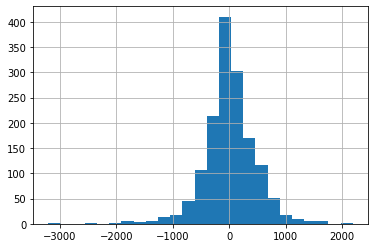

In [7]:
# histogram of portfolio losses
df_simulation.Loss.hist(bins = 25)
# plt.savefig('losses.pdf')
print('Loss distribution')
plt.show()

# VaR and ES: Base Version

In [8]:
alpha = 0.99
df_loss = df_simulation[['Loss']].dropna().sort_values(by = 'Loss', ascending = False,ignore_index= True)
print('Loss distribution: from the worst to the best')
df_loss

Loss distribution: from the worst to the best


,Loss
0,2187.056608
1,1727.138918
2,1635.834020
3,1611.439287
4,1596.573364
...,...
1495,-1795.242955
1496,-1837.417918
1497,-2018.002490
1498,-2369.920910


### a)

In [9]:
losses = df_loss['Loss'].values

VaR  = np.percentile(losses, alpha * 100, interpolation = 'higher') 
ES = np.mean(losses [losses >= VaR])

print('VaR: ', VaR)
print('ES ', ES)

VaR:  1219.0999552080211
ES  1485.2810923350737


### b) exponential weighting scheme with lambda = 0:995;

In [17]:
df_loss = df_simulation[['Loss']].dropna().sort_values(by = 'Loss', ascending = False)
df_loss = df_loss.reset_index()
df_loss['index'] += 1
df_loss

,index,Loss
0,19,2187.056608
1,10,1727.138918
2,199,1635.834020
3,192,1611.439287
4,17,1596.573364
...,...,...
1495,49,-1795.242955
1496,272,-1837.417918
1497,264,-2018.002490
1498,181,-2369.920910


In [26]:
Lambda = 0.995
n = len(df_loss)
df_loss['Weight'] = np.power(Lambda, n - df_loss['index']) * (1- Lambda) / (1- np.power(Lambda, n))
df_loss['Cum Weight'] = np.cumsum(df_loss.Weight)
df_loss

,index,Loss,Weight,Cum Weight
0,19,2187.056608,0.000003,0.000003
1,10,1727.138918,0.000003,0.000006
2,199,1635.834020,0.000007,0.000013
3,192,1611.439287,0.000007,0.000020
4,17,1596.573364,0.000003,0.000023
...,...,...,...,...
1495,49,-1795.242955,0.000003,1.004990
1496,272,-1837.417918,0.000011,1.005001
1497,264,-2018.002490,0.000010,1.005011
1498,181,-2369.920910,0.000007,1.005018


In [28]:
print(n)
sum(df_loss['Weight'])

1500


1.005025125628141

In [24]:
weights = df_loss['Weight'].values
cum_weights = df_loss['Cum Weight'].values
losses_sorted = df_loss.Loss.values

cum_weights

array([2.97173637e-06, 5.81238819e-06, 1.31381998e-05, ...,
       9.99983228e-01, 9.99989922e-01, 9.99997285e-01])

In [30]:
alpha=0.99
weights = df_loss['Weight'].values
cum_weights = df_loss['Cum Weight'].values
losses_sorted = df_loss.Loss.values

Critial_index = np.where(cum_weights >= 1 - alpha, np.arange(n) , np.inf).argmin()
VaR  = df_loss.Loss.iloc[Critial_index]

w_for_ES = weights[0:Critial_index].tolist() + [1 - alpha - cum_weights[Critial_index-1]]
ES = np.sum( losses_sorted[0: Critial_index + 1] * w_for_ES )/ (1-alpha)

# print('Weight for ES: ', w_for_ES)

print('VaR: ', VaR)
print('ES ', ES)

VaR:  518.9153245025773
ES  614.1414051250174


### c) EVT with u = 300 (and equal weightings);

In [37]:
u = 300  #In general the rule of thumb for u is the 95 percentile of historical loss data
tail_losses = losses_sorted[losses_sorted > u]
n_u = len(tail_losses )

# Definition the og likelihood function 
def EVT_likelihood (paras):
    beta = paras[0]
    xi = paras[1]
    return  (-1/xi -1) * np.sum( np.log(1 + xi * (tail_losses - u)/beta ) ) - n_u * np.log(beta) 


x0 = (40, 0.3) #Initial guess of beta and xi
print('Initial guess of the (beta, xi) configuration: ', x0)
print('Log likelihood for the initial guess: ', EVT_likelihood ((30, 0.4)))

Initial guess of the (beta, xi) configuration:  (40, 0.3)
Log likelihood for the initial guess:  -2645.1516781425153


In [33]:
import scipy.optimize as opt

In [38]:
res = opt.minimize( lambda x: - EVT_likelihood (x)  , x0, method='trust-constr',  options={'disp': True})


beta_optimal, xi_optimal =  res.x

print('Optimal (beta, xi) configuration: ', beta_optimal, xi_optimal )
print('Log likelihood for the optimal solution : ', EVT_likelihood ((beta_optimal, xi_optimal)))

VaR = u + beta_optimal/xi_optimal * (np.power(n/n_u * (1-alpha),-xi_optimal) - 1)
ES  = (VaR + beta_optimal - xi_optimal * u)/(1 - xi_optimal)

print('VaR: ',  VaR)
print('ES ', ES)

`xtol` termination condition is satisfied.
Number of iterations: 51, function evaluations: 129, CG iterations: 71, optimality: 3.05e-05, constraint violation: 0.00e+00, execution time: 0.22 s.
Optimal (beta, xi) configuration:  313.3208431240222 -0.052111401559340596
Log likelihood for the optimal solution :  -2169.217693211998
VaR:  1189.6152755154105
ES  1443.3543224192358


In [ ]:
# `xtol` termination condition is satisfied.
# Number of iterations: 51, function evaluations: 129, CG iterations: 71, optimality: 3.05e-05, constraint violation: 0.00e+00, execution time: 0.21 s.
# Optimal (beta, xi) configuration:  313.3208431240222 -0.052111401559340596
# Log likelihood for the optimal solution :  -2169.217693211998
# VaR:  1189.6152755154105
# ES  1443.3543224192358

### d)  normally distributed with mean zero

In [41]:
df_loss['Loss'].describe()

count    1500.000000
mean        6.504418
std       455.182882
min     -3206.035505
25%      -215.217859
50%        -7.633875
75%       245.522352
max      2187.056608
Name: Loss, dtype: float64

In [42]:
from scipy.stats import norm

In [43]:
norm.ppf(0.99, loc=0, scale=455.182882)

1058.9137298404828

In [45]:
pm= 0
ps= 455.182882
# Compute the 95% VaR using the .ppf()
VaR_99 = norm.ppf(0.99, loc = pm, scale = ps)
# Compute the expected tail loss and the CVaR in the worst 5% of cases
tail_loss = norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_99)
CVaR_99 = tail_loss/ (1 - 0.99)
CVaR_99

1213.1598899643873

In [46]:
# df_simulation=data.copy()
# # df_simulation['Simulated Next day']= last_prices*(df_simulation.shift(periods=1).iloc[:, 1]/df_simulation.iloc[:, 1])
# df_simulation = df_simulation.shift(periods=1)
# df_simulation

In [12]:
# def fac(n,k):
#     fact = 1
#     for i in range(1,n+1): 
#         fact = fact * i
#     return fact
# fac(3)

6

In [22]:
# # from decimal import Decimal

# pr=0
# n=160
# k = 17 
# p= 0.01
# for i in range(17,151): 
#     a = (p**k)*((1-p)**(n-k))*math.factorial(n)/(math.factorial(k)*math.factorial(n-k))
# #     a = (p**k)*((1-p)**(n-k))*fac(n)/(fac(k)*fac(n-k))

# #     a = (p**k)*((1-p)**(n-k))*Decimal(math.factorial(n))/(Decimal(math.factorial(k))*Decimal(math.factorial(n-k))
# pr= pr+a
# print(pr)
                                                   

8.170846838407909e-13
